We will be using a dataset containing a number of behavioral attributes for credit card customers that I obtained from Kaggle [here](https://www.kaggle.com/arjunbhasin2013/ccdata).

We will be using scikit-learn in order to apply clustering to identify natural segments of the data set.

The dataset consists of 18 features about the behavior of credit card customers:
* CUST_ID : Identification of Credit Card holder (Categorical)
* BALANCE : Balance amount left in their account to make purchases (
* BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
* PURCHASES : Amount of purchases made from account
* ONEOFF_PURCHASES : Maximum purchase amount done in one-go
* INSTALLMENTS_PURCHASES : Amount of purchase done in installment
* CASH_ADVANCE : Cash in advance given by the user
* PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
* ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
* PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
* CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
* CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
* PURCHASES_TRX : Numbe of purchase transactions made
* CREDIT_LIMIT : Limit of Credit Card for user
* PAYMENTS : Amount of Payment done by user
* MINIMUM_PAYMENTS : Minimum amount of payments made by user
* PRCFULLPAYMENT : Percent of full payment paid by user
* TENURE : Tenure of credit card service for user

Standard imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning
***
First, load in the data:

In [19]:
data = pd.read_csv("data/credit_card_data.csv")

We look at the data types to see what we're working with, and if we need to transform anything

In [20]:
data.dtypes

CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

Then we can drop the `CUST_ID` column because it won't help at all for training, only serves as a primary key, and we can just use our default `RangeIndex` instead

In [21]:
cols_to_drop = ['CUST_ID']
data_no_cust_id = data.drop(cols_to_drop,axis=1)

We can check to see which features have any missing values:

In [22]:
data_no_cust_id.columns[data_no_cust_id.isna().sum()>0]

Index(['CREDIT_LIMIT', 'MINIMUM_PAYMENTS'], dtype='object')

Now we can check to see how bad it is, by looking at what fraction of entries in each of these columns is missing values.

In [23]:
data_no_cust_id.loc[:,data_no_cust_id.isna().sum()>0].isna().sum()/data_no_cust_id.shape[0]

CREDIT_LIMIT        0.000112
MINIMUM_PAYMENTS    0.034972
dtype: float64

Because both of the columns have less than 5% missing values, it should be reasonable to impute the missing values with the mean.

Because scikit-learn only likes to work with numpy arrays, we re cast the transformed data into a DataFrame with the same columns.

In [29]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
data_no_cust_id_imputed = pd.DataFrame(imp.fit_transform(data_no_cust_id),columns=data_no_cust_id.columns)

Now we should see that there are no missing values:

In [32]:
data_no_cust_id_imputed[['CREDIT_LIMIT','MINIMUM_PAYMENTS']].isna().sum()

CREDIT_LIMIT        0
MINIMUM_PAYMENTS    0
dtype: int64

# Feature Scaling
***
Now we need to scale the features because our clustering `KMeans` is scale-dependent, and sensitive to any differences in scale between the features of the dataset.

We will transform all of the features into the range [0,1] using the `MinMaxScaler`.

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data_no_cust_id_imputed),columns=data_no_cust_id_imputed.columns)

Let's check the scale just to be sure.

Before scaling:

In [36]:
data_no_cust_id_imputed.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.612411,2895.063757,2330.588021,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,335.628312,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,864.206542,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


After scaling:

In [35]:
scaled_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,0.082154,0.877271,0.020457,0.014534,0.018270,0.020766,0.490351,0.202458,0.364437,0.090096,0.026413,0.041089,0.148396,0.034170,0.011310,0.153715,0.919553
std,0.109306,0.236904,0.043570,0.040722,0.040193,0.044491,0.401371,0.298336,0.397448,0.133414,0.055485,0.069435,0.121490,0.057078,0.030503,0.292499,0.223055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006736,0.888889,0.000808,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.002793,0.051753,0.007556,0.002236,0.000000,1.000000
50%,0.045864,1.000000,0.007367,0.000932,0.003956,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,0.019553,0.098497,0.016894,0.004392,0.000000,1.000000
75%,0.107868,1.000000,0.022637,0.014166,0.020828,0.023629,0.916667,0.300000,0.750000,0.148148,0.032520,0.047486,0.215359,0.037482,0.011310,0.142857,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Clustering
***
So we've finished performing data transformations. Now we can start the unsupervised learning part. For KMeans, we need to decide on the hyperparameter, the number of clusters. In order to do this, we can look at the k-means inertia for many cluster sizes. Inertia is a measure of _within-cluster variation_, or homogeneity of a given cluster. We generally want a smaller inertia as that will have a lower amount of within cluster variation, and result in more homogeneity. 

Imports for Machine Learning

In [3]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

`n_init` is the number of initializations. Because the final clusterings depend on their initial locations, we can increase the number of initializations we try to get a better value. The output will be the best value we achieved with respect to inertia

`max_iter` is the number of max iterations the algorithm will run to reassign the cluster labels on observations in order to minimize inertia.

`tol` is the tolerance for settling on a stable clustering configuration to minimize the inertia

`random_state` is the seed we can set to make our experiments reproducible

`n_jobs` is a parameter we can pass to tell our computer to use extra threads to perform this computation in parallel

In [38]:
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 42
n_jobs = 8

In [40]:
# maximum number of clusters to test for hyperparameter
max_num_clusters = 21
# initialize empty dataframe to hold our inertia values
kMeans_inertia = pd.DataFrame( data=[], \
    index=range(2,max_num_clusters),columns=['inertia'])

# for each value of number of clusters
for n_clusters in range(2,max_num_clusters):
    # create a kMeans obj
    kmeans = KMeans( n_clusters=n_clusters, n_init=n_init,\
                    max_iter=max_iter, tol=tol, \
                    random_state=random_state, n_jobs=n_jobs )
    # fit it
    kmeans.fit( scaled_data )
    # extract the inertia
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

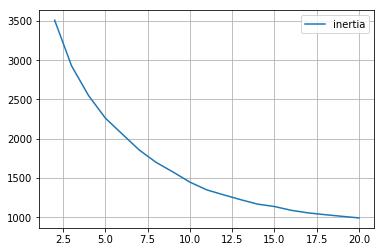

In [43]:
kMeans_inertia.plot();
plt.grid()

Looking at this graph, I say we should take 10 clusters.

Now, we need to split our set of data into a training and testing set, so that we can see if our algorithm resolves nice clusters on unseen data

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split( scaled_data,\
test_size=0.2, random_state=random_state )

In [48]:
optimal_n_clusters = 10
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=random_state)
kmeans.fit(X_train)

preds = kmeans.predict(X_test)

Now we can add another column to the test set, indicating the cluster it was classified in.

In [49]:
test_data_with_preds = X_test.copy()
test_data_with_preds['PREDICTED_CLUSTER'] = preds

Now we can look at the average values of the features for each of the clusters:

In [53]:
cols_to_summarize = ['PREDICTED_CLUSTER','BALANCE','PURCHASES','PURCHASES_FREQUENCY','CREDIT_LIMIT','ONEOFF_PURCHASES_FREQUENCY','MINIMUM_PAYMENTS','PRC_FULL_PAYMENT','PAYMENTS']

summary = test_data_with_preds[cols_to_summarize].groupby("PREDICTED_CLUSTER").mean()
summary

,BALANCE,PURCHASES,PURCHASES_FREQUENCY,CREDIT_LIMIT,ONEOFF_PURCHASES_FREQUENCY,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,PAYMENTS
PREDICTED_CLUSTER,,,,,,,,
0,0.074737,0.004367,0.190566,0.111037,0.089195,0.006493,0.034091,0.012660
1,0.082994,0.016213,0.534096,0.135784,0.122946,0.011746,0.054883,0.027947
2,0.163963,0.082914,0.971717,0.246294,0.732869,0.016050,0.068830,0.081197
3,0.005915,0.020994,0.932408,0.123414,0.051618,0.002499,0.783875,0.021905
4,0.011436,0.008042,0.123162,0.126549,0.061357,0.004650,0.068046,0.033999
5,0.075569,0.023938,0.952749,0.115918,0.082897,0.018398,0.054784,0.032638
6,0.113511,0.003495,0.074116,0.132899,0.057427,0.013300,0.019284,0.026872
7,0.021311,0.082342,0.956154,0.248045,0.890510,0.002538,0.883172,0.079074
8,0.086876,0.030364,0.737267,0.157272,0.707120,0.009400,0.058303,0.031746


After looking at the `PURCHASES_FREQUENCY` column, we see that our model did find some clusters who, on average, have close to the maximum value of `PURCHASES_FREQUENCY` (clusters 2,3,5,7).

# Dimensionality Reduction to plot the Clusters
***
Now that we've done some clustering. Let's do a quick dimensionality reduction technique to make a nice-looking plot to see if we can visualize these clusters in two dimensions.

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(scaled_data.columns),random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

Now we can plot the first two principal components, along with cluster label:

In [60]:
X_test_PCA = pd.DataFrame(X_test_PCA[:,0:2],columns=['First Component','Second Component'])
X_test_PCA['PREDICTED_CLUSTER'] = preds

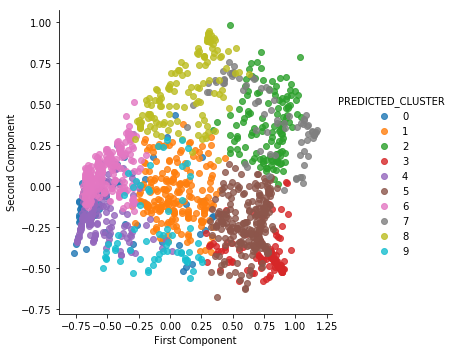

In [61]:
sns.lmplot(x='First Component',y='Second Component',hue='PREDICTED_CLUSTER',data=X_test_PCA,fit_reg=False);

Well, I wouldn't say this is very good, as almost every single cluster has at least some overlap, and several of them entirely overlap. This could be due to the fact of how many clusters we used, or it could be do to the fact that we are not reconstructing as much of the explained variance as is necessary to clearly separate these clusters in simply the first two principal components.

We can investigate the explained variance in the first few principal components to take a look at this question.

First of all, I would expect the total explained variance over all components to be 1, since I've used as many principal components as there are columns in the data set. This is just a sanity check:

In [62]:
sum(pca.explained_variance_ratio_)

0.9999999999999997

Now we can plot the explained variance versus the number of principal components used:

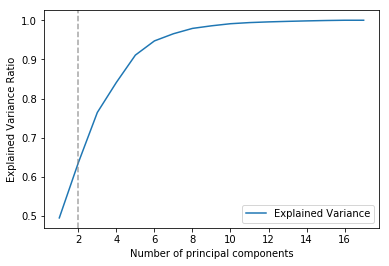

In [78]:
explainedVariance = pd.DataFrame(data=pca.explained_variance_ratio_,columns=['Explained Variance'],\
                                index=range(1,1+len(scaled_data.columns)))
explainedVariance.cumsum().plot();
plt.xlabel("Number of principal components");
plt.ylabel("Explained Variance Ratio");
plt.axvline(2,label='2 Principal Components',color='grey',alpha=0.7,linestyle='dashed');

As we can see, using only the first two principal components only yields something like 60% of the variance:

In [73]:
explainedVariance[:2].sum()

Explained Variance    0.636061
dtype: float64

# Putting it all in a Pipeline
***
We would prefer to put all of our transformations and analysis inside a robust pipeline so that it is organized, reproducible, and we can make changes easily, as well as test with many different configurations of the various transformers.

First, I am going to write a custom transformer to drop the `CUST_ID` as an example of how to create such a simple transformer.

In [119]:
from sklearn.base import BaseEstimator, TransformerMixin
# inheriting from TransformerMixing gives me fit_transform for free
# inheriting from BaseEstimator gives me get_params and set_params for free
# this will allow me to do automatic hyperparameter tuning (changing cols to drop)
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop, verbose=False ):
        print(cols_to_drop)
        assert isinstance(cols_to_drop,list),"Cols to drop must be a list"
        self.cols_to_drop_ = cols_to_drop
        self.verbose = verbose
    def fit(self, X, y=None):
        self.all_cols = X.columns
        self.new_cols_ = [col for col in self.all_cols if col not in self.cols_to_drop_ ]
        return self
    def transform(self, X):
        newX = X.loc[:, self.new_cols_].copy()
        if self.verbose:
            print("New columns:",newX.columns)
        return newX

Now we can construct our pipeline:

In [120]:
from sklearn.pipeline import Pipeline

clustering_pipeline = Pipeline([
    ('drop_cust_id',DropCols(['CUST_ID'])),
    ('imputer',SimpleImputer(strategy="mean")),
    ('scaler',MinMaxScaler()),
    ('clustering',KMeans(n_clusters=optimal_n_clusters, n_init=n_init,\
                    max_iter=max_iter, tol=tol, \
                    random_state=random_state, n_jobs=n_jobs))
])

['CUST_ID']


And we can use it like this:

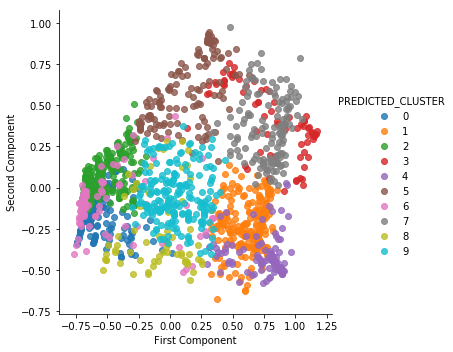

In [121]:
X_train_pipeline = clustering_pipeline.fit_transform(X_train)
pipeline_preds = clustering_pipeline.predict(X_test)

X_test_PCA['PREDICTED_CLUSTER'] = pipeline_preds
sns.lmplot(x='First Component',y='Second Component',hue='PREDICTED_CLUSTER',data=X_test_PCA,fit_reg=False);